In [ ]:
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten, Dense, concatenate,Conv2D,Input,MaxPooling2D,add,Activation
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 as SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

### **VGG-16**

![picture](https://miro.medium.com/max/850/1*_Lg1i7wv1pLpzp2F4MLrvw.png)

In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

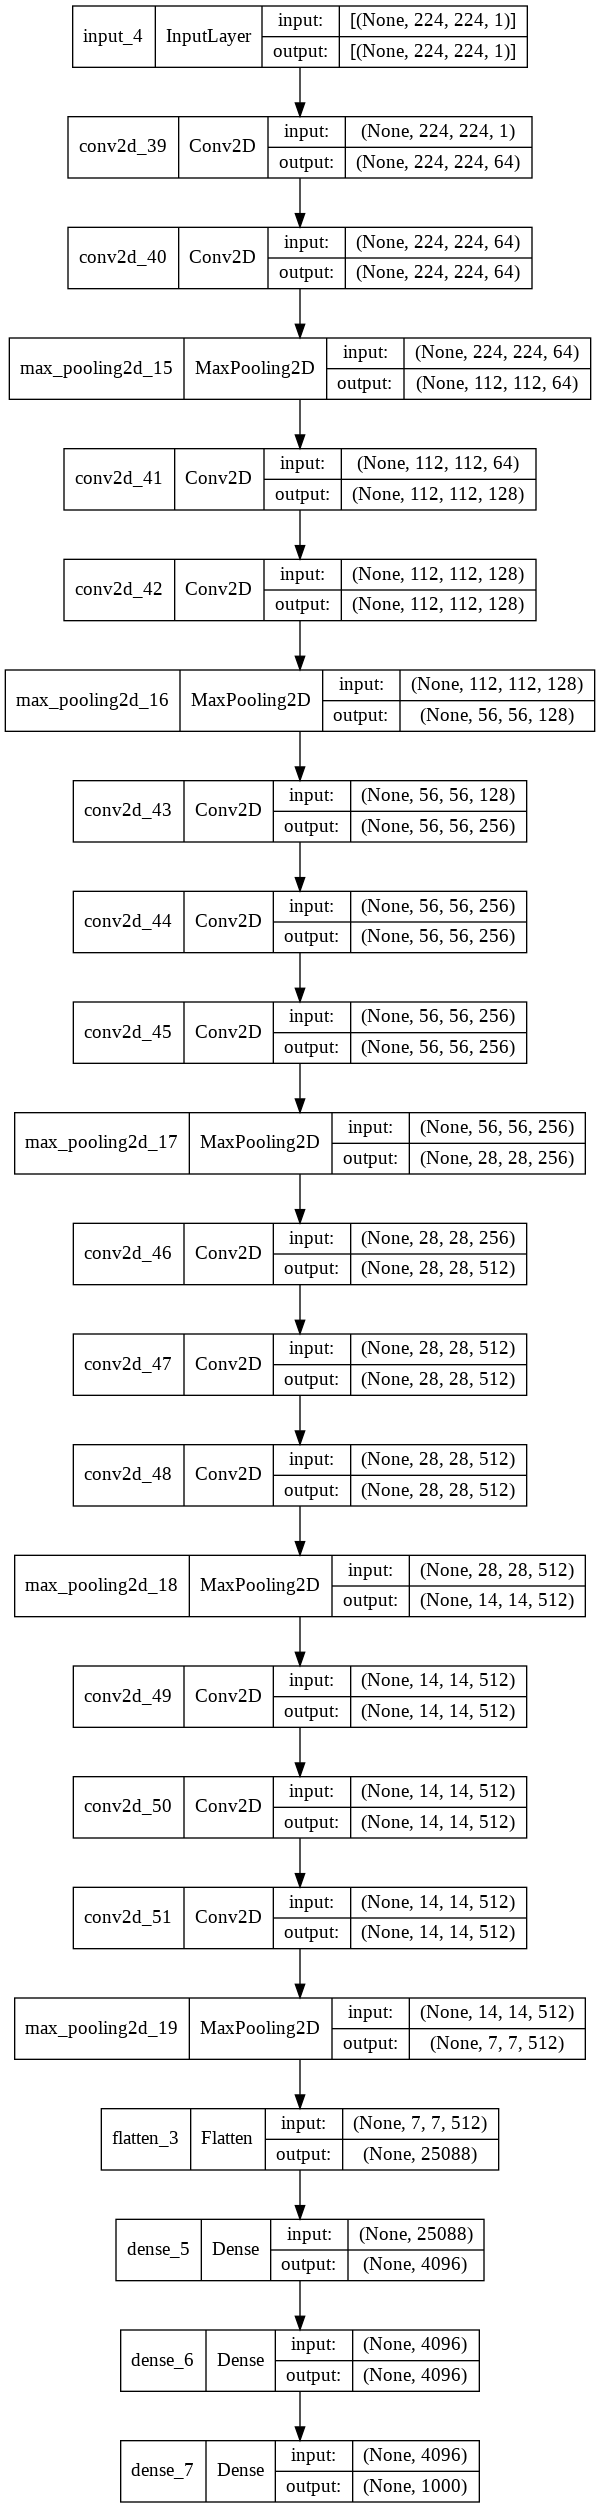

In [ ]:
# define model input
visible = Input(shape=(224, 224,1))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 3)
# add vgg module
layer = vgg_block(layer, 512, 3)
# add vgg module
layer = vgg_block(layer, 512, 3)
# add flatten Layer
layer = Flatten()(layer)
# add Dense Layer
layer= Dense(4096, activation='relu')(layer)
# add Dense Layer
layer= Dense(4096, activation='relu')(layer)
# add Dense Layer
layer= Dense(1000, activation='relu')(layer)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

### Inception

![picture](https://images2.programmerclick.com/294/94/94a109a2751777e2a15c779364f06e46.png)

In [ ]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 256, 256, 96  384         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 256, 256, 16  64          ['input_7[0][0]']                
                                )                                                           

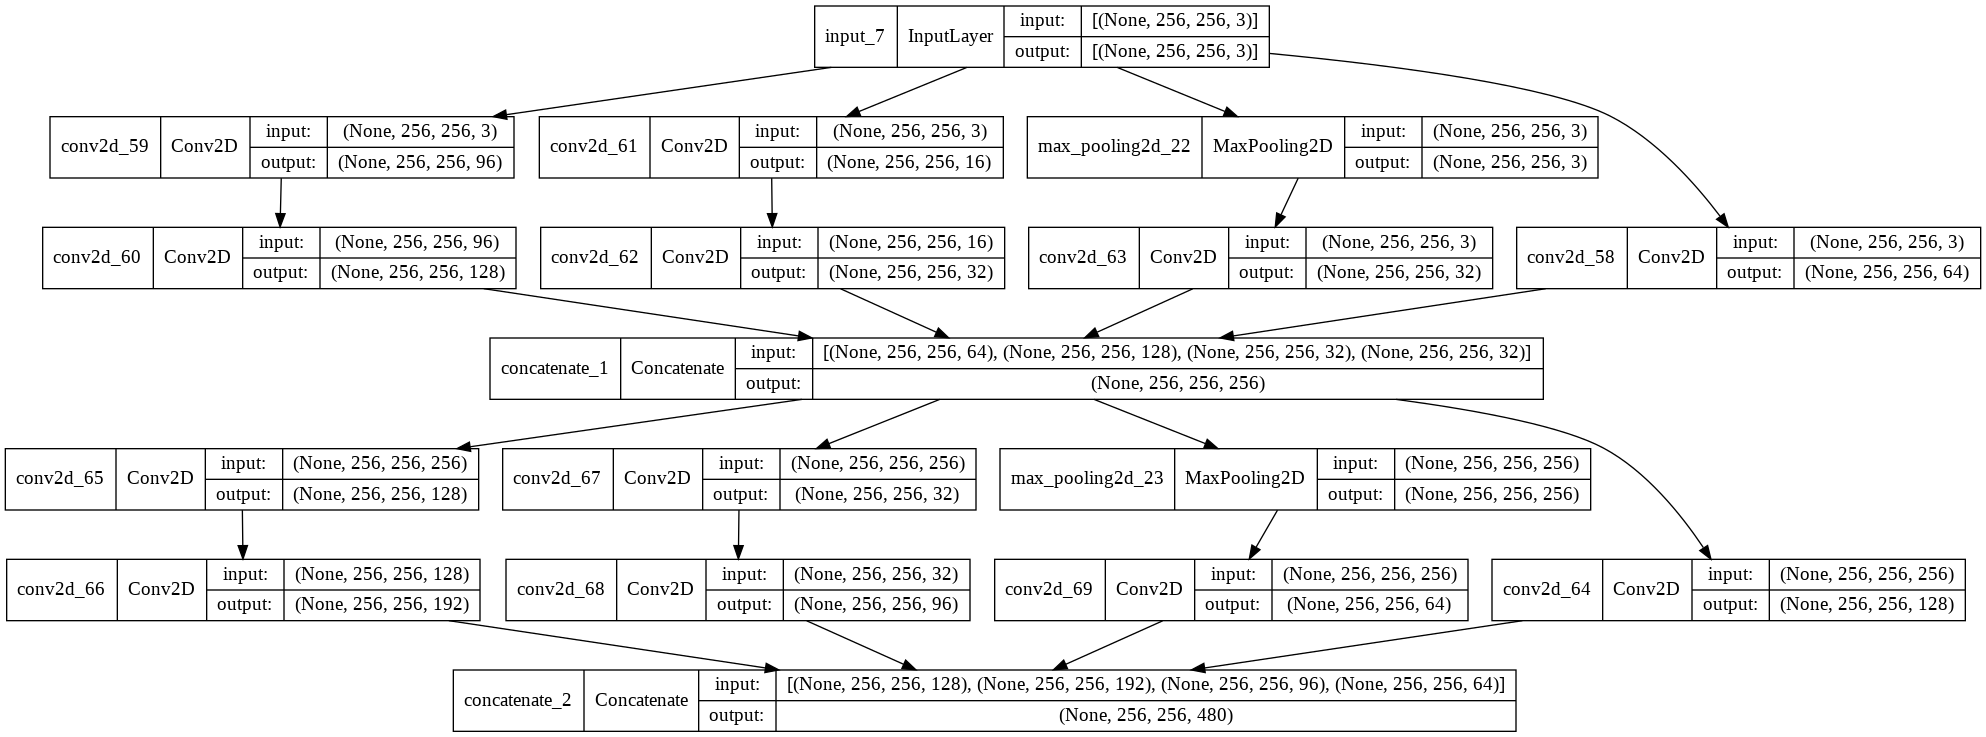

In [ ]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

### ResNet50

![picture](https://www.researchgate.net/profile/Sulabh-Kumra/publication/310953119/figure/fig2/AS:433232907902982@1480302182569/Example-of-residual-block-in-ResNet.png)

In [ ]:
# Identity block
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
# Convolutional block
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# model ResNet50
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

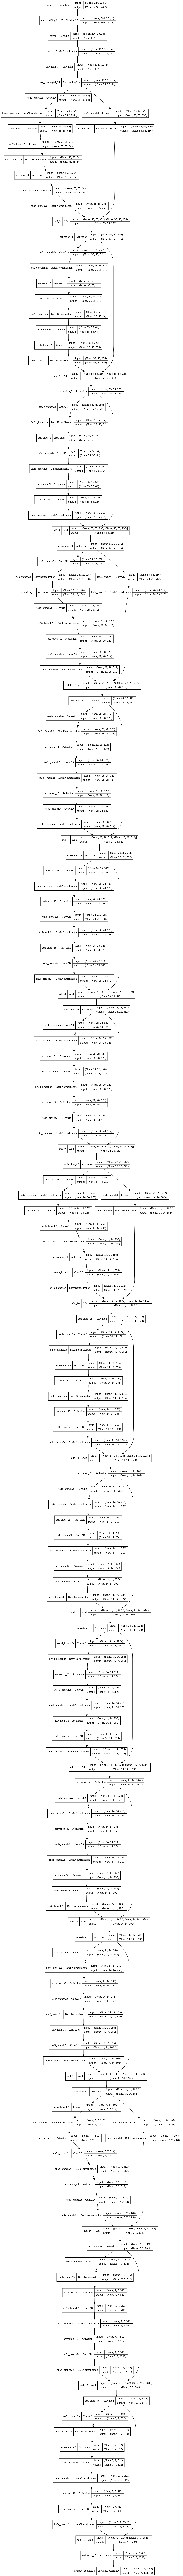

In [ ]:
plot_model(base_model, show_shapes=True, to_file='resnet50.png')